#### Imports

In [1]:
# import fiftyone as fo
# import fiftyone.zoo as foz
# from fiftyone import ViewField as F
# import numpy as np
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
# from tensorflow.keras import layers
import tensorflow as tf
from tensorflow.keras.applications import VGG19
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg19 import preprocess_input
import scipy
from tensorflow.keras.models import load_model
import numpy as np
import os
from PIL import Image
import IPython.display as display

In [2]:
# print(tf.keras.__version__)
print(tf.__version__)

2.16.1


In [3]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print(tf.config.list_physical_devices())

Num GPUs Available:  0
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]


#### Script Variables

In [4]:
# Data genration
my_classes = ["Alpaca", "Camel", "Dog"]
# script_dir = os.path.dirname(os.path.abspath(__file__))
# base_export_dir = f"{script_dir}/Data"
# 
# # Data split
# max_samples = 400
# train_split = 0.8

## Generate Dataset + Data-Split

In [5]:
# for animal_class in my_classes:
# 
#     print(f"start loading of {animal_class}")
# 
#     # Load dataset
#     dataset = foz.load_zoo_dataset(
#         "open-images-v7",
#         dataset_name = f"{animal_class}_{max_samples}",
#         split="train",
#         label_types=["detections"],
#         classes= [animal_class],
#         max_samples=max_samples,
#         shuffle=True
#     )
# 
#     # Filter the dataset to only include specified classes
#     dataset = dataset.filter_labels("ground_truth", F("label").is_in(animal_class))
# 
#     patches = dataset.to_patches("ground_truth")
# 
#     # Splitting the dataset into train and test subsets
#     train_patches = patches.take(np.floor(train_split * len(patches)), seed=42)  # 80% of the data for training
#     train_ids = train_patches.values("id")
#     test_patches = patches.exclude(train_ids)  # The rest for testing
# 
#     print(f"\n {animal_class} Train/Test-Split:")
#     print(f"train: {len(train_patches)/len(patches)*100}%")
#     print(f"test: {len(test_patches)/len(patches)*100}%\n")
# 
# 
#     # Export train dataset
#     train_export_dir = f"{base_export_dir}/train"
#     train_patches.export(
#         export_dir=train_export_dir,
#         dataset_type=fo.types.ImageClassificationDirectoryTree,
#         label_field="ground_truth",
#     )
# 
#     # Export test dataset
#     test_export_dir = f"{base_export_dir}/test"
#     test_patches.export(
#         export_dir=test_export_dir,
#         dataset_type=fo.types.ImageClassificationDirectoryTree,
#         label_field="ground_truth",
#     )


## Implementieren des Models
Schritt 1: Laden vortrainiertes VGG19 Models (mit imagenet)

In [6]:
# vortrainiertes Model
base_model = VGG19(weights='imagenet', include_top=False, input_shape=(150, 150, 3)) 

Schritt 2: Defintion des Models (Layer Aktivierungsfunktion)

In [7]:
# model mit layers und aktivierungsfunktion 
model = Sequential([
    base_model,
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(3, activation='softmax')  # Für 3 Klassen
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 4, 4, 512)         20024384  
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 256)               2097408   
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 3)                 771       
                                                                 
Total params: 22,122,563
Trainable params: 22,122,563
Non-trainable params: 0
_________________________________________________________________


Schritt 3: Hyperparameter Definieren

In [8]:
# Hier machst du alle Schichten des VGG19-Modells nicht-trainierbar, sodass ihre Gewichte während des Trainings nicht aktualisiert werden. 
# Das Modell wird dann mit dem Adam-Optimierer, der binären Kreuzentropie als Verlustfunktion und Genauigkeit als Metrik kompiliert.
for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer=Adam(learning_rate=0.1),
              loss='categorical_crossentropy',  # Verwende categorical_crossentropy
              metrics=['accuracy'])


Schritt 4: Daten Laden

In [9]:
datagen = ImageDataGenerator(validation_split=0.2)  # Nutze einen Teil der Daten für die Validierung

train_data = datagen.flow_from_directory(
    'Data/train/',  # Gehe eine Ebene höher, um alle Klassen einzuschließen
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',  # Ändere auf categorical
    subset='training'  # Trainingsdaten
)

validation_data = datagen.flow_from_directory(
    'Data/train/',  # Gehe eine Ebene höher, um alle Klassen einzuschließen
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',  # Ändere auf categorical
    subset='validation'  # Validierungsdaten
)

Found 1258 images belonging to 3 classes.
Found 313 images belonging to 3 classes.


Schritt 5: Model Training

In [10]:
print(scipy.__version__)

1.12.0


In [11]:
history = model.fit(
    train_data,
    epochs=10,
    validation_data=validation_data
)

# # Zugriff auf die Trainingsgenauigkeit und Validierungsgenauigkeit
# train_accuracy = history.history['accuracy']
# val_accuracy = history.history['val_accuracy']
# 
# # Drucke die Genauigkeit für jede Epoche
# for i in range(len(train_accuracy)):
#     print(f"Epoche {i+1}, Training Accuracy: {train_accuracy[i]}, Validation Accuracy: {val_accuracy[i]}")


Epoch 1/10
40/40 [==============================] - 19s 357ms/step - loss: 1437.1141 - accuracy: 0.5048 - val_loss: 29.7646 - val_accuracy: 0.5240
Epoch 2/10
40/40 [==============================] - 9s 225ms/step - loss: 189.8356 - accuracy: 0.4658 - val_loss: 46.3599 - val_accuracy: 0.5016
Epoch 3/10
40/40 [==============================] - 9s 224ms/step - loss: 29.1429 - accuracy: 0.4587 - val_loss: 74.4339 - val_accuracy: 0.4696
Epoch 4/10
40/40 [==============================] - 9s 225ms/step - loss: 28.4464 - accuracy: 0.4650 - val_loss: 88.7727 - val_accuracy: 0.4089
Epoch 5/10
40/40 [==============================] - 9s 224ms/step - loss: 5.1191 - accuracy: 0.4817 - val_loss: 265.9795 - val_accuracy: 0.4920
Epoch 6/10
40/40 [==============================] - 9s 225ms/step - loss: 10.1209 - accuracy: 0.4603 - val_loss: 261.8170 - val_accuracy: 0.4696
Epoch 7/10
40/40 [==============================] - 9s 227ms/step - loss: 29.6137 - accuracy: 0.4555 - val_loss: 261.7909 - val_acc

# Notizen

In [12]:
# Erstelle einen ImageDataGenerator für die Testdaten
test_datagen = ImageDataGenerator(rescale=1./255)  # Normalisiere die Bilder

# Lade die Testdaten
test_generator = test_datagen.flow_from_directory(
        'Data/test',  # Dies ist der Pfad zum Testordner
        target_size=(150, 150),  # Stelle sicher, dass dies der Größe entspricht, die dein Modell erwartet
        batch_size=32,  # Kann je nach Speicherkapazität angepasst werden
        class_mode='categorical',  # 'binary' falls du eine Binärklassifizierung hast
        shuffle=False)  # Wichtig für die Evaluierung, um die Reihenfolge beizubehalten

# Evaluierung des Modells mit den Testdaten
loss, accuracy = model.evaluate(test_generator)

print(f'Test Loss: {loss}')
print(f'Test Accuracy: {accuracy}')

Found 395 images belonging to 3 classes.
13/13 [==============================] - 4s 270ms/step - loss: 1.0972 - accuracy: 0.3671
Test Loss: 1.0972446203231812
Test Accuracy: 0.3670886158943176


In [13]:
def classify_image(img_path, model, classes):
    # Bild anzeigen
    with Image.open(img_path) as img:
        display.display(img)
    # Bild laden und vorbereiten
    img = image.load_img(img_path, target_size=(150, 150))  # Stelle sicher, dass dies der Größe entspricht, die dein Modell erwartet
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)
    
    # Vorhersage
    predictions = model.predict(img_array)
    print(predictions)
    
    # Ermittle die Klasse mit der höchsten Wahrscheinlichkeit
    predicted_class_index = np.argmax(predictions, axis=1)[0]
    predicted_class = classes[predicted_class_index]
    
    return predicted_class, predictions[0][predicted_class_index]

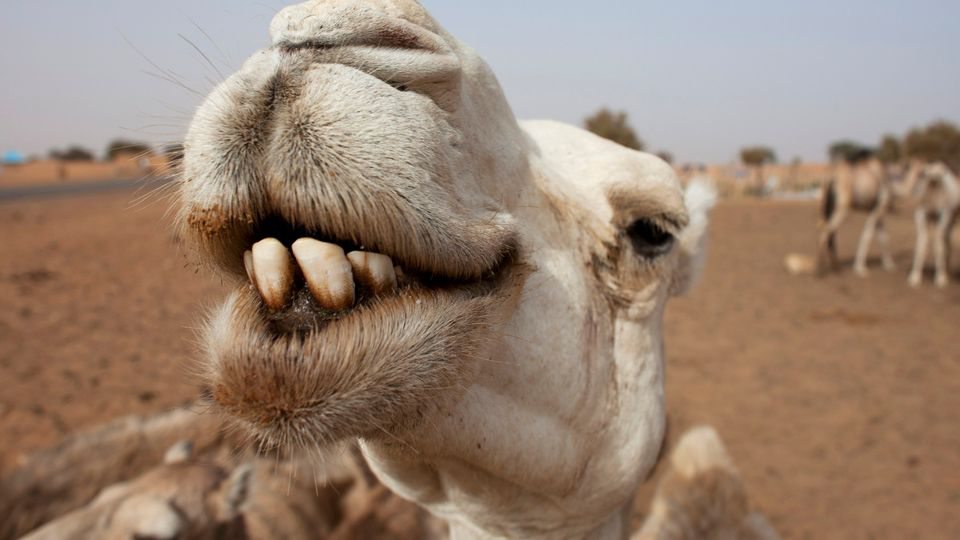

1/1 [==============================] - 1s 847ms/step
[[0.38465434 0.30581757 0.3095281 ]]
Das Modell hat das Bild klassifiziert als: ('Alpaca', 0.38465434)


In [14]:
# Klassifiziere das Bild und printe das Ergebnis
image_path = 'kamel.jpg'
predicted_class = classify_image(image_path, model, my_classes)
print(f'Das Modell hat das Bild klassifiziert als: {predicted_class}')

Schritt X: Data augmantation

In [15]:
def custom_preprocessing_function(image):
    """
    Führt benutzerdefinierte Datenanreicherung wie Kontraständerung auf einem Bild aus.
    """
    # Zufällige Kontraständerung
    image = tf.image.random_contrast(image, lower=0.5, upper=1.5)
    # Weitere benutzerdefinierte Transformationen können hier hinzugefügt werden
    return image

# Erstelle einen ImageDataGenerator mit der benutzerdefinierten Funktion
datagen = ImageDataGenerator(
    # Zufällige horizontale Spiegelung
    horizontal_flip=True, 
    # width_shift_range und height_shift_range für zufällige Translationen
    width_shift_range=0.2, # horizontale Verschiebung
    height_shift_range=0.2, # vertikale Verschiebung
    preprocessing_function=custom_preprocessing_function,  # Füge die benutzerdefinierte Verarbeitungsfunktion hinzu
    validation_split=0.2
)

Schritt 4: ....

In [16]:
train_data_augmentation = datagen.flow_from_directory(
    'Data/train/',  # Gehe eine Ebene höher, um alle Klassen einzuschließen
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',  # Ändere auf categorical
    subset='training'  # Trainingsdaten
)

validation_data_augmentation = datagen.flow_from_directory(
    'Data/train/',  # Gehe eine Ebene höher, um alle Klassen einzuschließen
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',  # Ändere auf categorical
    subset='validation'  # Validierungsdaten
)

Found 1258 images belonging to 3 classes.
Found 313 images belonging to 3 classes.


Schritt 5: ....

In [17]:
model.fit(
    train_data_augmentation,
    # steps_per_epoch=541 // 32,  # Anzahl der Bilder geteilt durch die Batch-Größe
    epochs=10,
    validation_data=validation_data_augmentation
)

Epoch 1/10
40/40 [==============================] - 24s 606ms/step - loss: 1.9710 - accuracy: 0.3967 - val_loss: 16.1572 - val_accuracy: 0.4058
Epoch 2/10
40/40 [==============================] - 24s 595ms/step - loss: 10.0434 - accuracy: 0.3736 - val_loss: 16.6848 - val_accuracy: 0.3962
Epoch 3/10
40/40 [==============================] - 23s 580ms/step - loss: 2.3060 - accuracy: 0.3847 - val_loss: 58.7138 - val_accuracy: 0.4281
Epoch 4/10
40/40 [==============================] - 23s 586ms/step - loss: 7.9318 - accuracy: 0.3728 - val_loss: 3.2025 - val_accuracy: 0.3738
Epoch 5/10
40/40 [==============================] - 24s 600ms/step - loss: 1.4749 - accuracy: 0.3609 - val_loss: 45.1241 - val_accuracy: 0.3770
Epoch 6/10
40/40 [==============================] - 24s 601ms/step - loss: 1.8664 - accuracy: 0.3617 - val_loss: 26.2837 - val_accuracy: 0.3674
Epoch 7/10
40/40 [==============================] - 23s 584ms/step - loss: 2.2331 - accuracy: 0.3712 - val_loss: 14.3906 - val_accuracy:

In [18]:
test_generator = datagen.flow_from_directory(
        'Data/test',  # Dies ist der Pfad zum Testordner
        target_size=(150, 150),  # Stelle sicher, dass dies der Größe entspricht, die dein Modell erwartet
        batch_size=32,  # Kann je nach Speicherkapazität angepasst werden
        class_mode='categorical',  # 'binary' falls du eine Binärklassifizierung hast
        shuffle=False)  # Wichtig für die Evaluierung, um die Reihenfolge beizubehalten

# Evaluierung des Modells mit den Testdaten
loss, accuracy = model.evaluate(test_generator)

print(f'Test Loss: {loss}')
print(f'Test Accuracy: {accuracy}')

Found 395 images belonging to 3 classes.
13/13 [==============================] - 6s 452ms/step - loss: 1.0467 - accuracy: 0.3013
Test Loss: 1.0467076301574707
Test Accuracy: 0.3012658357620239


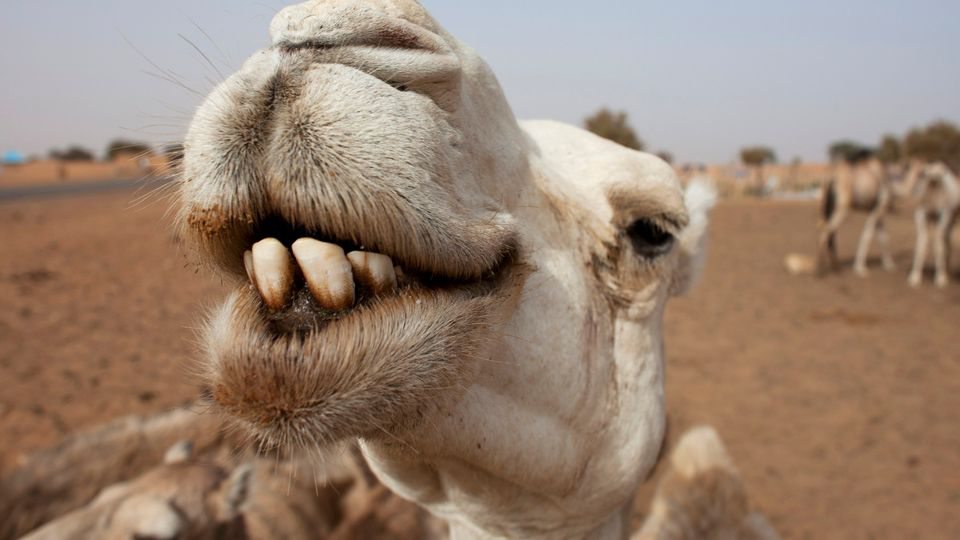

1/1 [==============================] - 0s 30ms/step
[[0.33402506 0.3296157  0.3363593 ]]
Das Modell hat das Bild klassifiziert als: ('Dog', 0.3363593)


In [19]:
predicted_class = classify_image(image_path, model, my_classes)
print(f'Das Modell hat das Bild klassifiziert als: {predicted_class}')

## Experiment with architecture:

In [20]:
from tensorflow.keras.applications import VGG19
from tensorflow.keras.layers import Conv2D, LeakyReLU, MaxPooling2D, Dense, GlobalAveragePooling2D, Flatten, Input
from tensorflow.keras.models import Model

# Lade das VGG19-Modell bis zum block4_conv4
base_model = VGG19(weights='imagenet', include_top=False)
model = Model(inputs=base_model.input, outputs=base_model.get_layer('block4_conv4').output)

# Füge die zusätzlichen Schichten hinzu

# Naive Inception Layer
tower_1 = Conv2D(256, (1, 1), padding='same', activation='relu')(model.output)
tower_2 = Conv2D(256, (3, 3), padding='same', activation='relu')(model.output)
tower_3 = Conv2D(256, (5, 5), padding='same', activation='relu')(model.output)
tower_4 = MaxPooling2D((3, 3), strides=(1, 1), padding='same')(model.output)
tower_4 = Conv2D(128, (1, 1), padding='same', activation=LeakyReLU(alpha=0.1))(tower_4)

# Kombiniere die Ausgänge der Türme
mixed = tf.keras.layers.concatenate([tower_1, tower_2, tower_3, tower_4], axis=-1)

# Führe eine Normalisierung der Anzahl der Filter durch
naive_inception_output = Conv2D(512, (1, 1), padding='valid', activation=LeakyReLU(alpha=0.1))(mixed)

# Weitere Convolutional Layer
output = Conv2D(512, (3, 3), padding='valid', strides=2, activation='relu')(naive_inception_output)
output = Conv2D(640, (1, 1), padding='valid', strides=1, activation='relu')(output)

# Füge einen GlobalAveragePooling2D Layer hinzu wegen categorical_crossentropy als Loss Funktion 
output = GlobalAveragePooling2D()(output)
# Füge einen Dense Layer mit einer softmax Aktivierung hinzu
num_classes = len(my_classes)
predictions = Dense(num_classes, activation='softmax')(output)

# Erstelle das neue Modell
# new_model = Model(inputs=model.input, outputs=conv_layer_2)
new_model = Model(inputs=model.input, outputs=predictions)

# Freeze conv2 layers and before
for layer in new_model.layers:
    layer.trainable = False
    if layer.name == 'max_pooling2d':
        break

# Zusammenfassung des neuen Modells anzeigen
new_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 block1_conv1 (Conv2D)          (None, None, None,   1792        ['input_2[0][0]']                
                                64)                                                               
                                                                                                  
 block1_conv2 (Conv2D)          (None, None, None,   36928       ['block1_conv1[0][0]']           
                                64)                                                         

In [21]:
for layer in new_model.layers:
    print(layer.name, layer.trainable)

input_2 False
block1_conv1 False
block1_conv2 False
block1_pool False
block2_conv1 False
block2_conv2 False
block2_pool False
block3_conv1 False
block3_conv2 False
block3_conv3 False
block3_conv4 False
block3_pool False
block4_conv1 False
block4_conv2 False
block4_conv3 False
block4_conv4 False
max_pooling2d False
conv2d True
conv2d_1 True
conv2d_2 True
conv2d_3 True
concatenate True
conv2d_4 True
conv2d_5 True
conv2d_6 True
global_average_pooling2d True
dense_2 True


In [22]:
new_model.compile(optimizer=Adam(learning_rate=0.1),
              loss='categorical_crossentropy',  # Verwende categorical_crossentropy wegen Mehrklassen-Klassifizierungsaufgabe
              metrics=['accuracy'])

new_model.fit(
    train_data_augmentation,
    # steps_per_epoch=541 // 32,  # Anzahl der Bilder geteilt durch die Batch-Größe
    epochs=10,
    validation_data=validation_data_augmentation
)

Epoch 1/10
40/40 [==============================] - 28s 626ms/step - loss: 1996688896.0000 - accuracy: 0.3537 - val_loss: 1.0912 - val_accuracy: 0.3674
Epoch 2/10
40/40 [==============================] - 24s 602ms/step - loss: 1.0947 - accuracy: 0.3672 - val_loss: 1.0927 - val_accuracy: 0.3674
Epoch 3/10
40/40 [==============================] - 24s 605ms/step - loss: 1.0942 - accuracy: 0.3720 - val_loss: 1.0923 - val_accuracy: 0.3578
Epoch 4/10
40/40 [==============================] - 24s 599ms/step - loss: 1.0973 - accuracy: 0.3625 - val_loss: 1.0911 - val_accuracy: 0.3674
Epoch 5/10
40/40 [==============================] - 24s 606ms/step - loss: 1.0952 - accuracy: 0.3466 - val_loss: 1.0912 - val_accuracy: 0.3674
Epoch 6/10
40/40 [==============================] - 24s 604ms/step - loss: 1.0951 - accuracy: 0.3688 - val_loss: 1.0947 - val_accuracy: 0.3674
Epoch 7/10
40/40 [==============================] - 24s 592ms/step - loss: 1.0965 - accuracy: 0.3545 - val_loss: 1.0908 - val_accurac

In [23]:
# model testen
new_model.evaluate(test_generator)

13/13 [==============================] - 6s 479ms/step - loss: 1.1042 - accuracy: 0.3671


[1.1042370796203613, 0.3670886158943176]

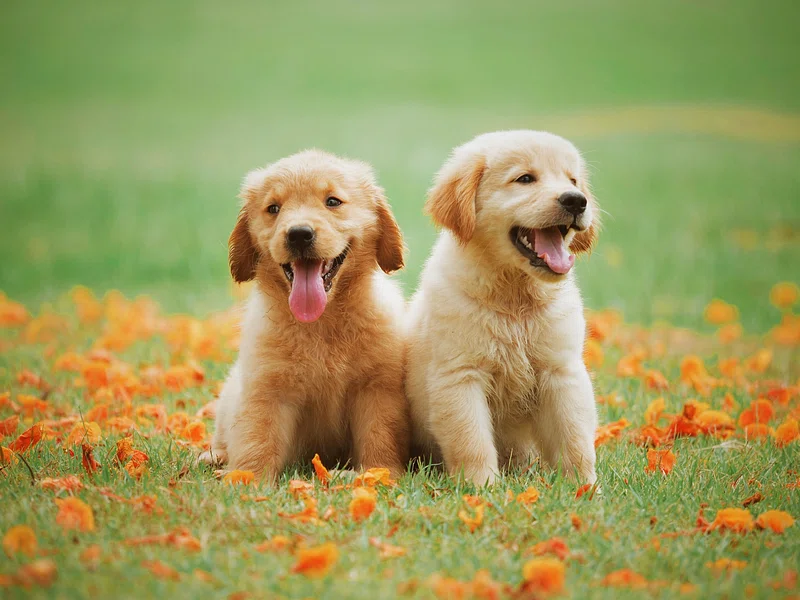

1/1 [==============================] - 0s 462ms/step
[[0.44425178 0.3295614  0.22618686]]
Das Modell hat das Bild klassifiziert als: ('Alpaca', 0.44425178)


In [24]:
image_path = 'dog.webp'
predicted_class = classify_image(image_path, new_model, my_classes)
print(f'Das Modell hat das Bild klassifiziert als: {predicted_class}')

1/1 [==============================] - 1s 843ms/step


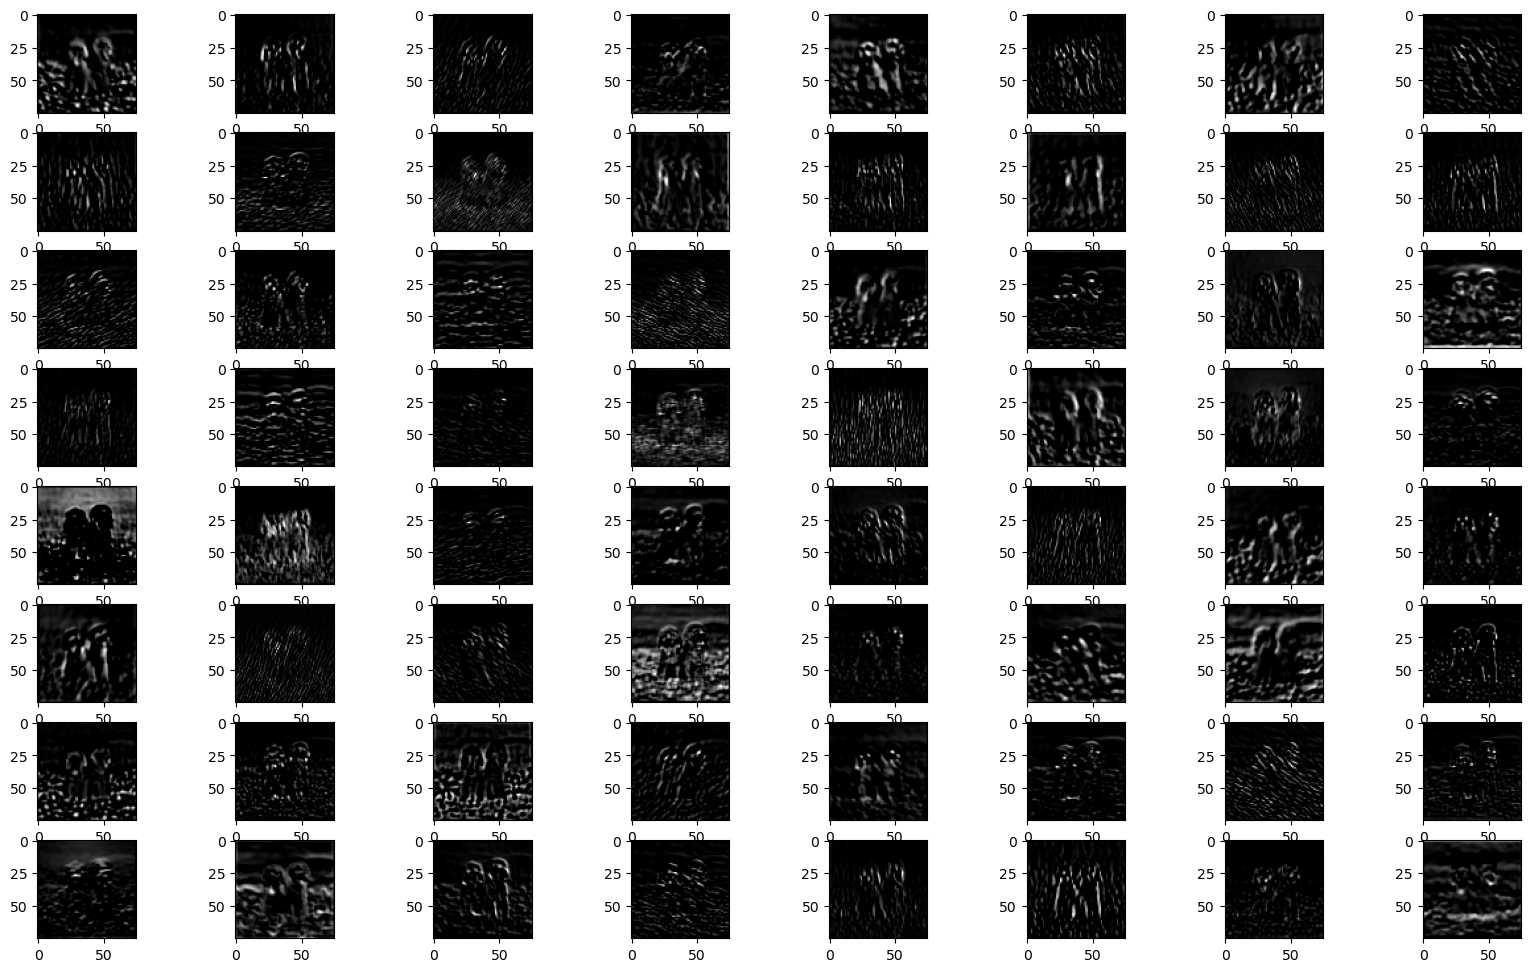

In [29]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming `model` is your TensorFlow/Keras model and `img_path` is the path to the image you want to test

# Load and preprocess the image
img = image.load_img(image_path, target_size=(150, 150))  # Adjust the target size to your model's input shape
img_array = image.img_to_array(img)
img_array_expanded_dims = np.expand_dims(img_array, axis=0)
img_preprocessed = preprocess_input(img_array_expanded_dims)

# Create a model that will return the outputs of intermediate layers
layer_outputs = [layer.output for layer in new_model.layers[1:]]  # Skip the input layer
activation_model = Model(inputs=new_model.input, outputs=layer_outputs)

# Get the activations
activations = activation_model.predict(img_preprocessed)

# Function to plot the activations of specific layers
def display_activation(activations, col_size, row_size, act_index): 
    activation = activations[act_index]
    activation_index=0
    fig, ax = plt.subplots(row_size, col_size, figsize=(row_size*2.5, col_size*1.5))
    for row in range(0, row_size):
        for col in range(0, col_size):
            ax[row][col].imshow(activation[0, :, :, activation_index], cmap='gray')
            activation_index += 1

# Example: Displaying the activations of the 5th layer
display_activation(activations, 8, 8, 4)  # Adjust col_size, row_size as per the number of filters in your layer
